In [1]:
from aleph_alpha_client import ImagePrompt, AlephAlphaModel, AlephAlphaClient, CompletionRequest, Prompt, QaRequest, QaResponse, Document, SemanticEmbeddingRequest, SemanticRepresentation, Prompt
import os
import cv2
import math
import plotly.graph_objects as go
from IPython.display import Image, display, Video
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
def embed_symmetric(text, model):
    prompt = Prompt.from_text(text)
    request = SemanticEmbeddingRequest(
        prompt=prompt, 
        representation=SemanticRepresentation.Symmetric
    )
    result = model.semantic_embed(request)
    return result.embedding

def cosine_similarity(v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]
        y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)

In [4]:
def capture_frames(path_to_video, wanted_fps):
    capture = cv2.VideoCapture(path_to_video)
    fps = capture.get(cv2.CAP_PROP_FPS)
    take_every_nth_frame = round(fps / wanted_fps)
    dir_name = path_to_video[:-4]
    os.makedirs(dir_name, exist_ok=True)
    i = 0
    success, frame = capture.read()
    while success:
        if i % take_every_nth_frame == 0:
            cv2.imwrite(f"{dir_name}/frame_{i:10d}.jpg", frame)
        success, frame = capture.read()
        i += 1

In [5]:
def embed_frames(path_to_video, model):
    path_to_frames_dir = path_to_video[:-4]
    frame_embeddings = list()
    image_names = os.listdir(path_to_frames_dir)
    image_names.sort()

    for image_name in image_names:
        image_path = f"{path_to_frames_dir}/{image_name}"
        promt = ImagePrompt.from_file(image_path)
        frame_embeddings.append(embed_symmetric(promt, model))
    return frame_embeddings

In [6]:
def score_similarity(frame_embeddings, query_embedding):
    frame_sim_scores = list()
    for frame_embedding in frame_embeddings:
        frame_sim_scores.append(
            cosine_similarity(
                query_embedding,
                frame_embedding
            )
        )
    return frame_sim_scores

In [30]:
def show_sim_over_time(frame_sim_scores, path_to_video, wanted_fps, top_k=1):
    fig = go.Figure(data=go.Scatter(
        x=[i / wanted_fps for i in range(len(frame_sim_scores))], 
        y=frame_sim_scores))
    fig.update_layout(
        xaxis_title="Seconds", yaxis_title="Cosine Similarity"
    )
    fig.show()
    
    display(Video(path_to_video, width=900))
    
    path_to_frames_dir = path_to_video[:-4]
    image_names = os.listdir(path_to_frames_dir)
    image_names.sort()
    image_paths_with_scores = list(zip(image_names, frame_sim_scores))
    for frame_path, cos_sim in sorted(image_paths_with_scores, key=lambda x: x[1], reverse=True)[:top_k]:
        display(Image(f"{path_to_frames_dir}/{frame_path}"))

In [8]:
def search(video_path, query, model, wanted_fps=5, frame_embeddings=False, show_top_k=3):
    if not frame_embeddings:
        capture_frames(video_path, wanted_fps)
        frame_embeddings = embed_frames(video_path, model)
    query_embedding = embed_symmetric(query, model)
    frame_sim_scores = score_similarity(frame_embeddings, query_embedding)
    show_sim_over_time(frame_sim_scores, video_path, wanted_fps, top_k=show_top_k)
    return frame_embeddings

In [25]:
model = AlephAlphaModel(
    AlephAlphaClient(host="https://api.aleph-alpha.com",
                     token=os.environ.get("API_TOKEN")),
    model_name="luminous-base"
)

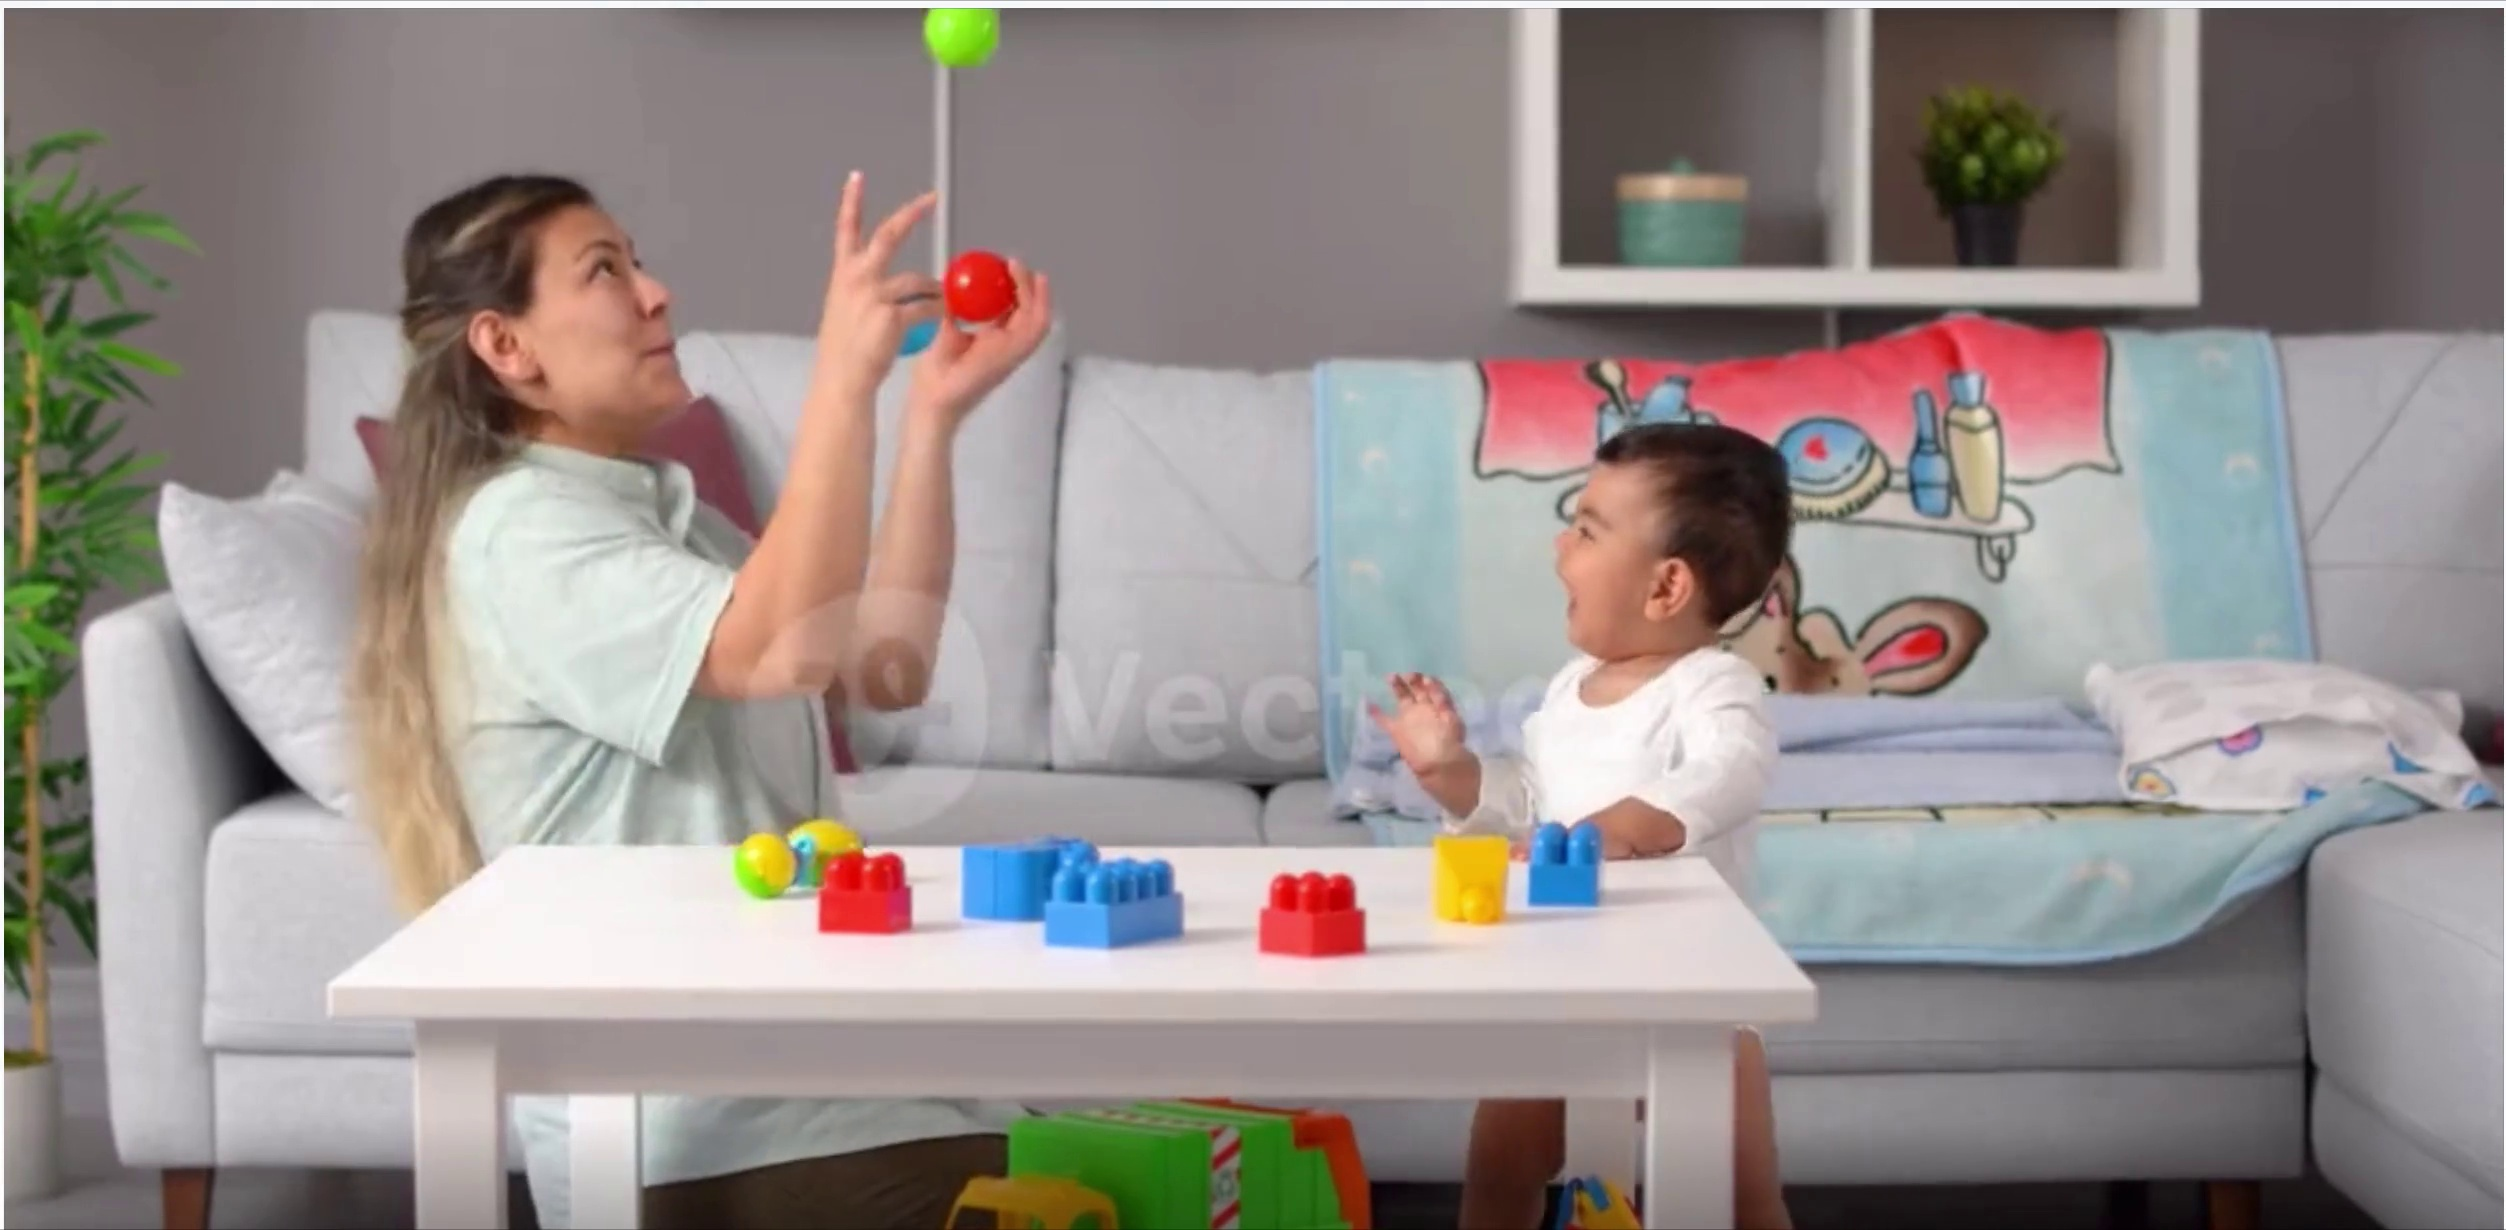

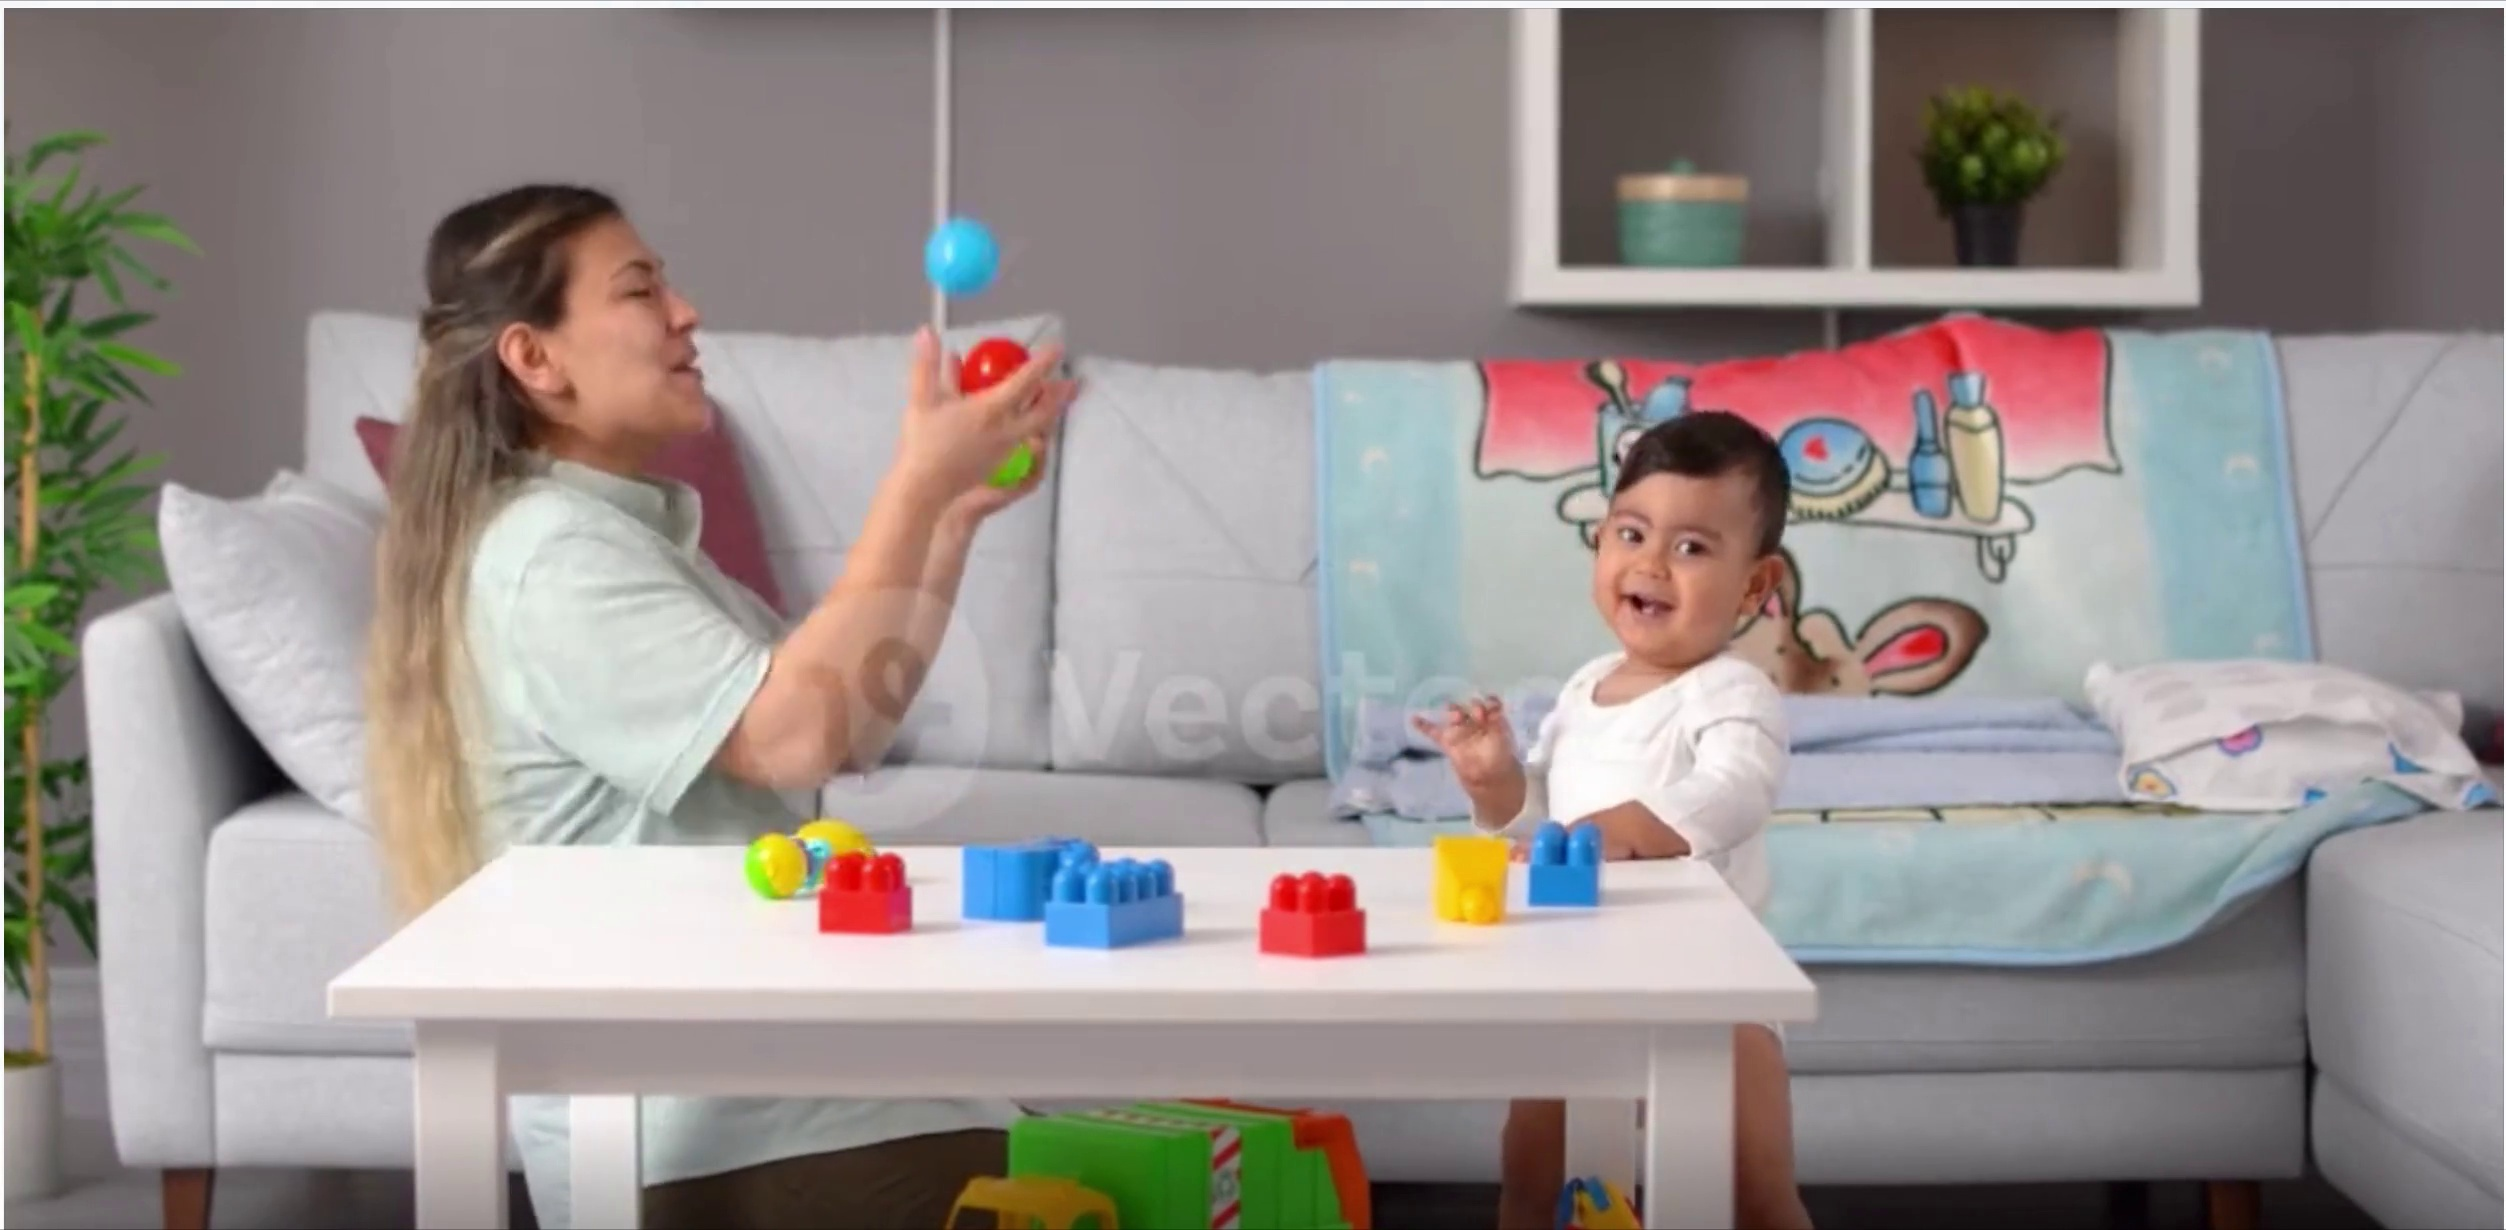

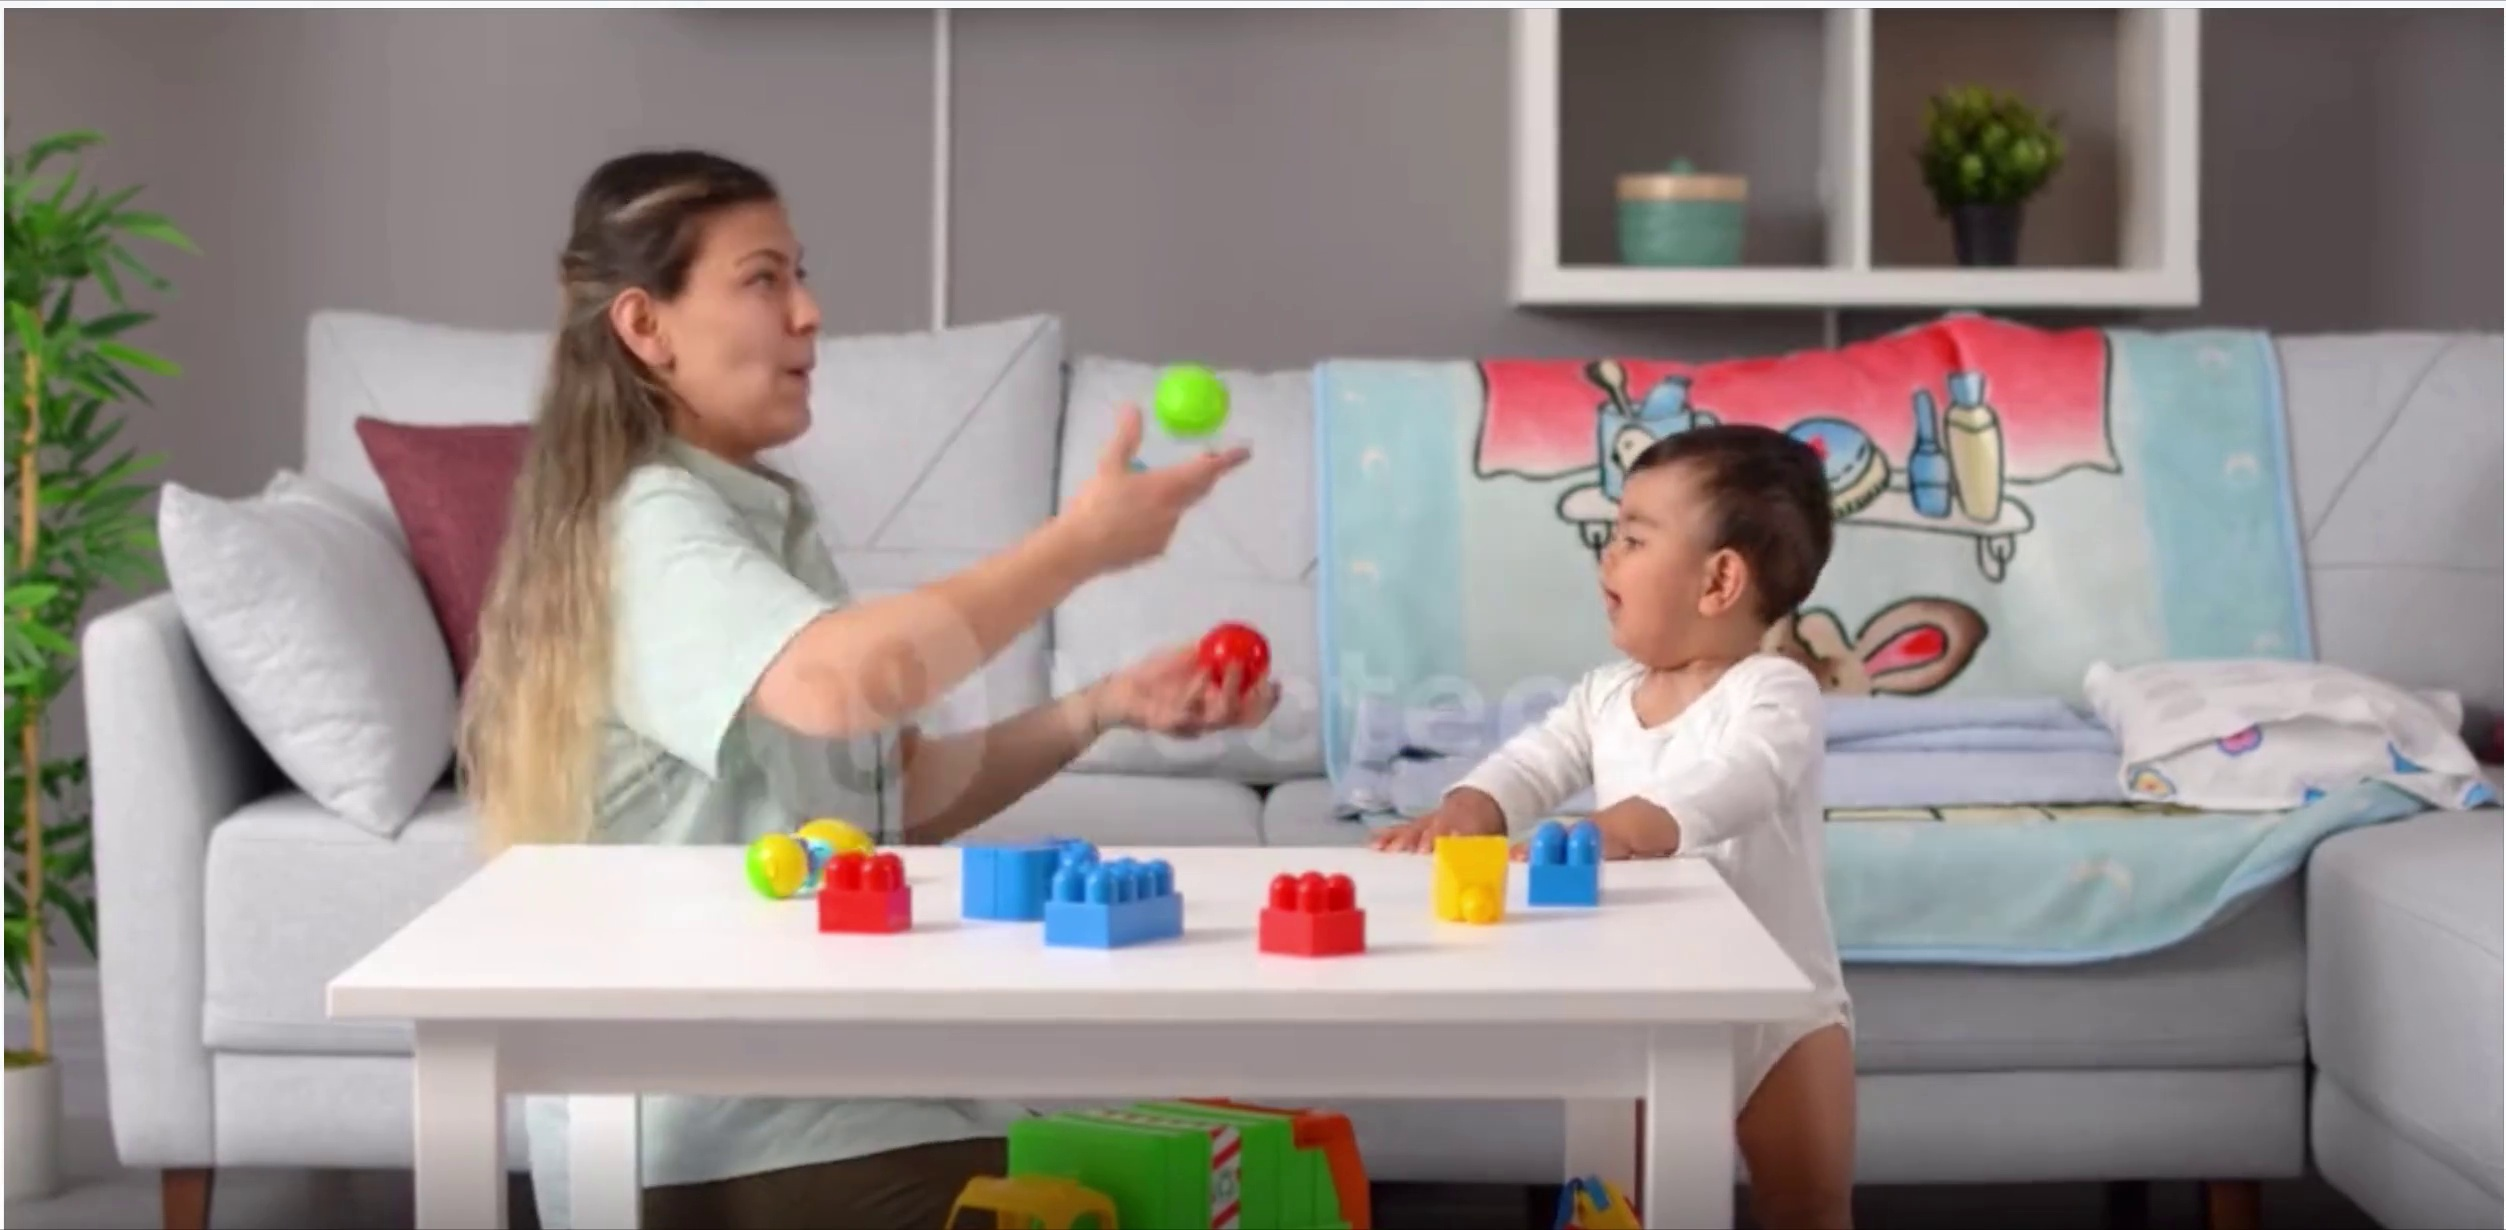

In [26]:
frame_embeddings_throwing_ball = search("throwing_ball.mp4", "ball in the air", model)

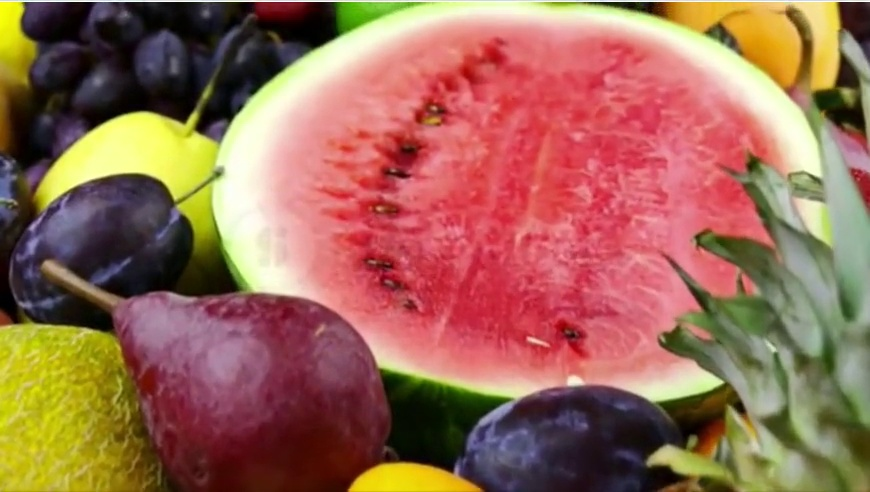

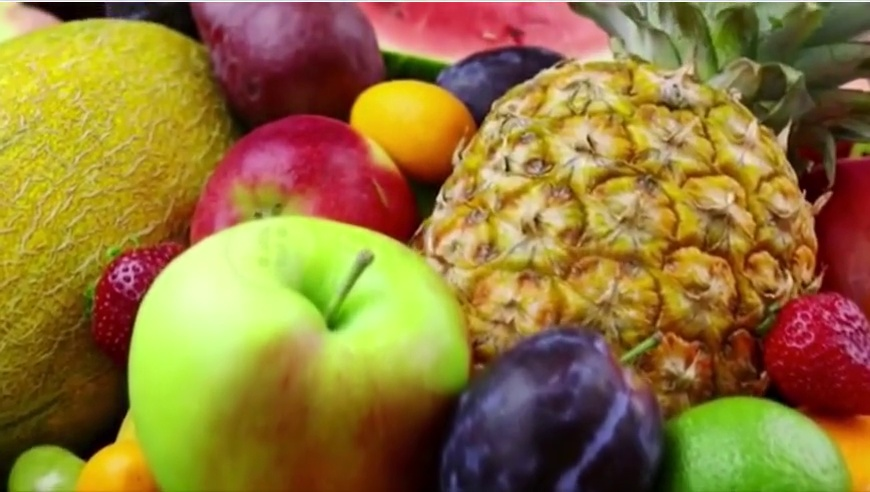

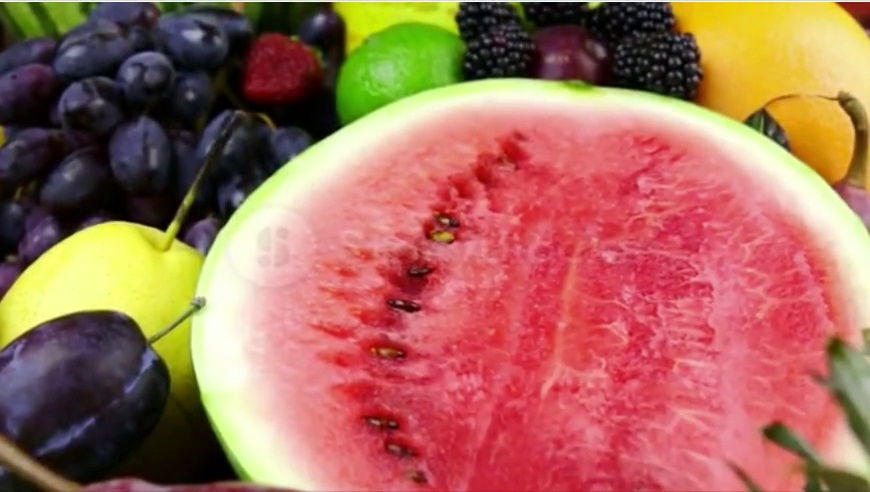

In [31]:
frame_embeddings_fruits = search("fruits.mp4", "pineapple", model, frame_embeddings=frame_embeddings_fruits)

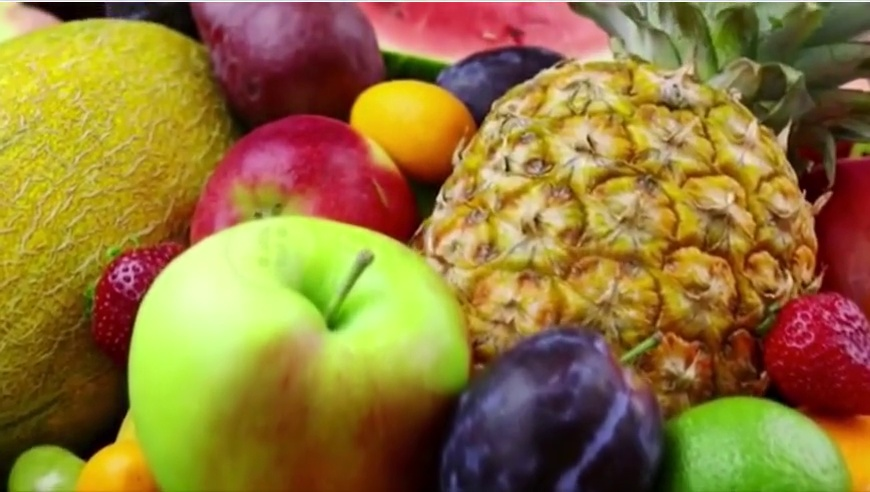

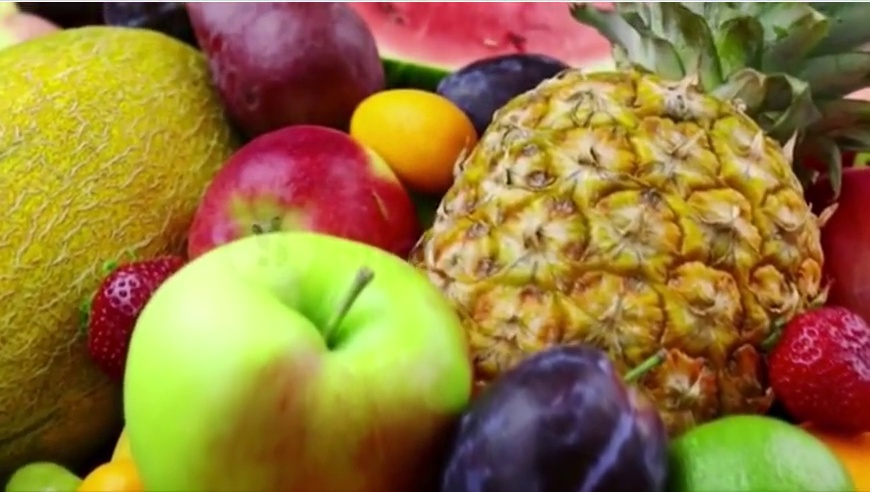

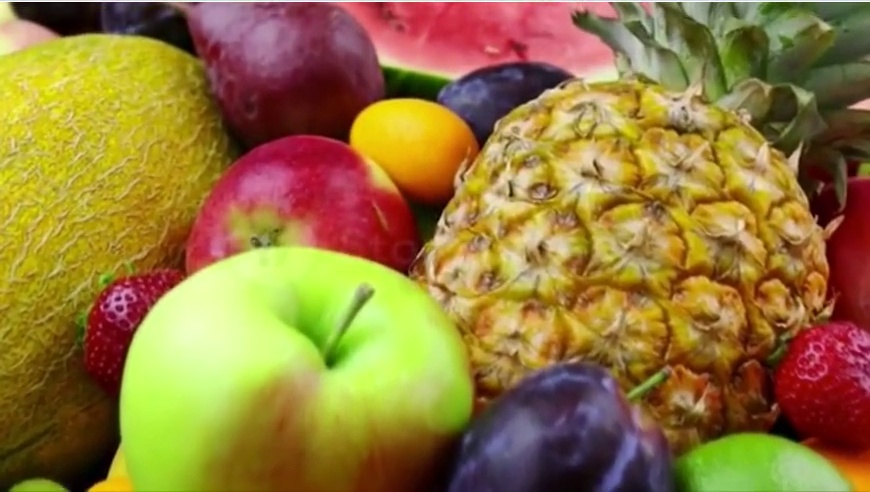

In [20]:
frame_embeddings_fruits = search("fruits.mp4", "pineapple in the middle", model, frame_embeddings=frame_embeddings_fruits)

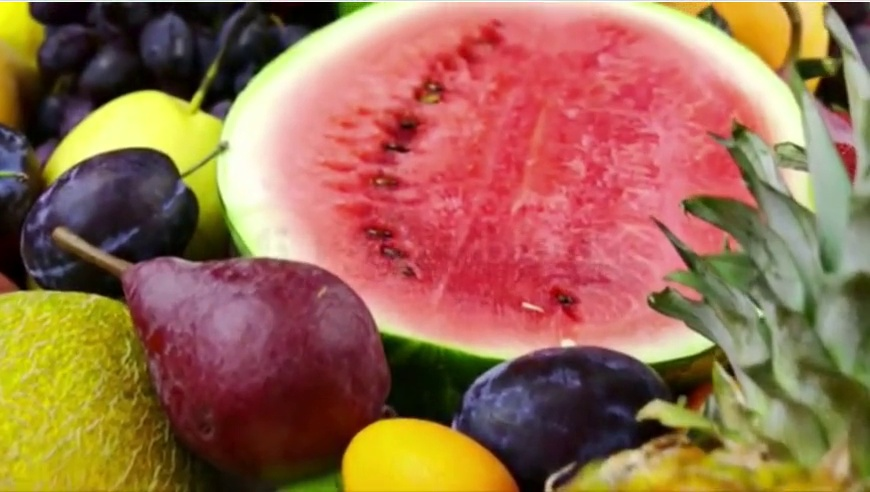

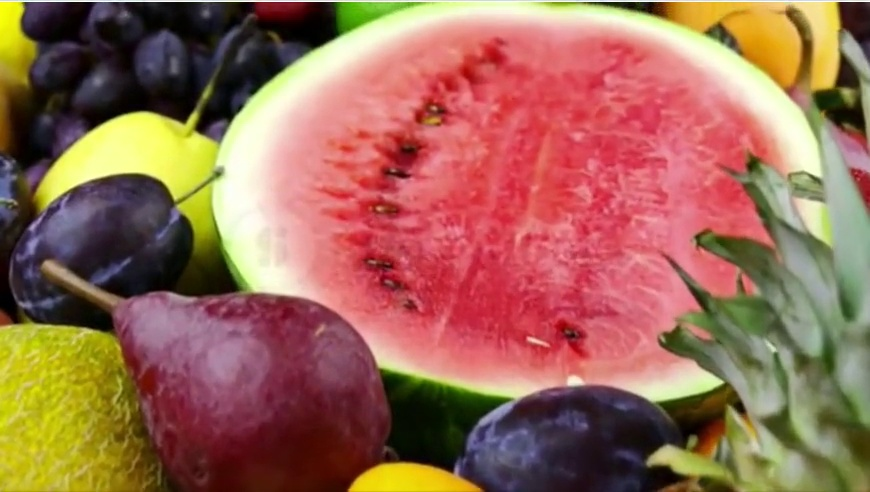

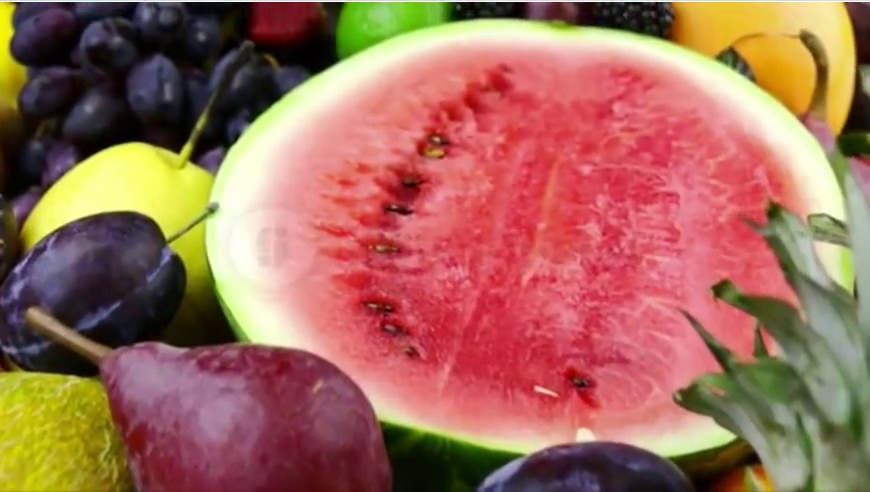

In [12]:
_ = search(
    "fruits.mp4", 
    "kumquats", 
    model, 
    frame_embeddings=frame_embeddings_fruits)

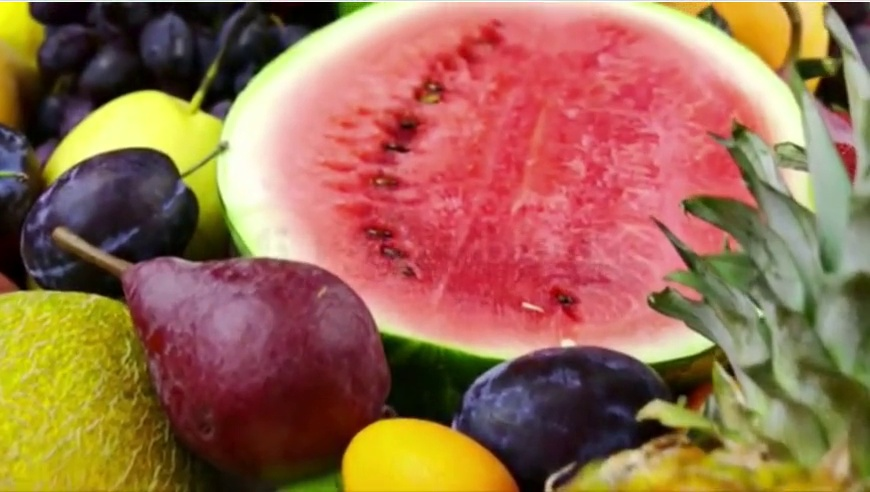

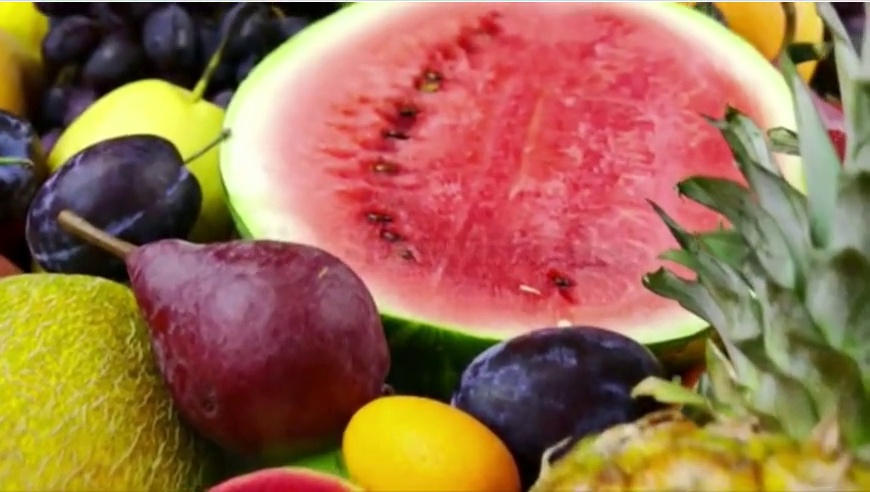

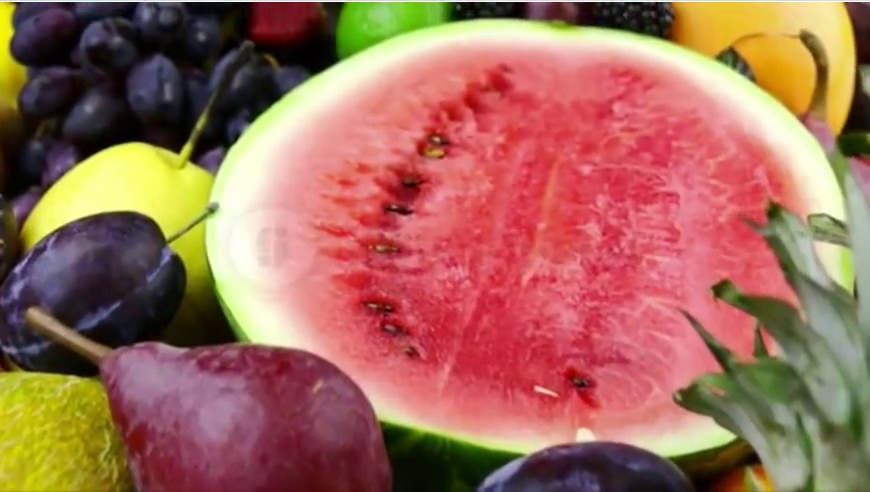

In [13]:
_ = search(
    "fruits.mp4", 
    "kumquats and no watermelon", 
    model, 
    frame_embeddings=frame_embeddings_fruits)